## Import Statements

In [1]:
import pandas as pd
import math
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import scatter_matrix

## Reading the data file

In [2]:
tree_data = pd.read_csv("Ex02_TreeData_Regreesion.csv")

FileNotFoundError: File b'Ex02_TreeData_Regreesion.csv' does not exist

In [75]:
tree_data.is_copy=False

## Basic Analysis

In [64]:
tree_data.corr()

,N0,Nt,pH,PetalCount,Age
N0,1.000000,0.080825,0.053488,0.127779,-0.058794
Nt,0.080825,1.000000,0.003821,-0.003614,-0.980478
pH,0.053488,0.003821,1.000000,0.099505,0.007455
PetalCount,0.127779,-0.003614,0.099505,1.000000,0.053744
Age,-0.058794,-0.980478,0.007455,0.053744,1.000000


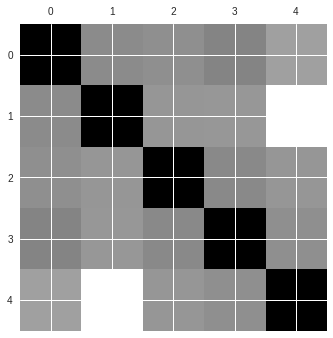

In [65]:
plt.matshow(tree_data.corr())
plt.show()

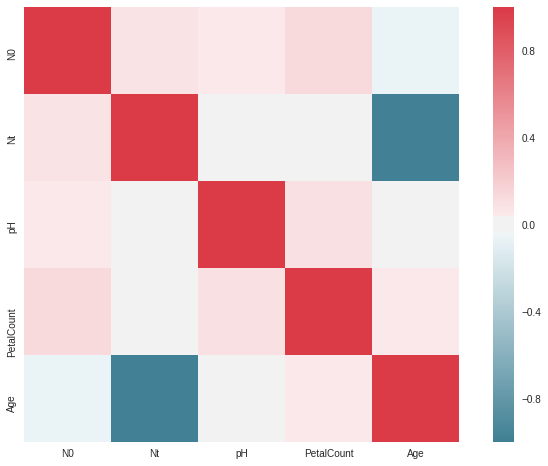

In [13]:
f, ax = plt.subplots(figsize=(12, 8))
corr = tree_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Scatter plots regressors vs regressand

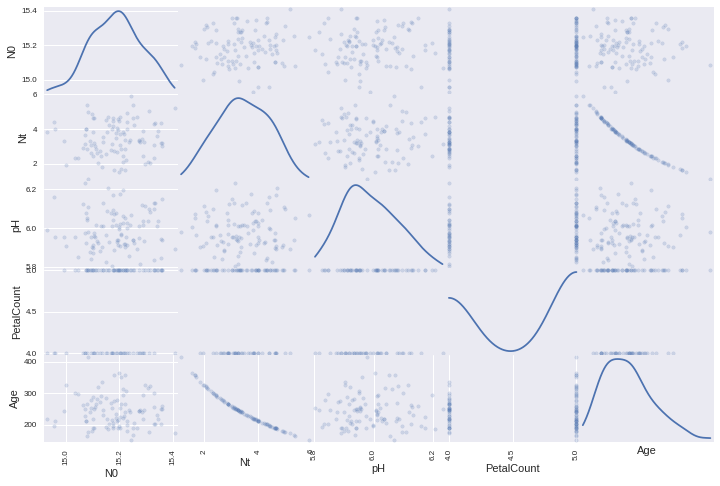

In [69]:
scatter_matrix(tree_data, alpha=0.2, figsize=(12, 8), diagonal='kde')
plt.xticks(())
plt.yticks(())
plt.show()

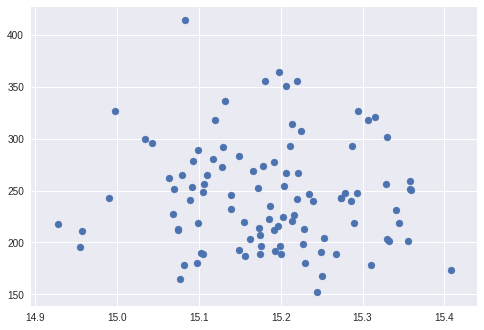

In [19]:
plt.scatter(tree_data.N0, tree_data.Age)
plt.show()

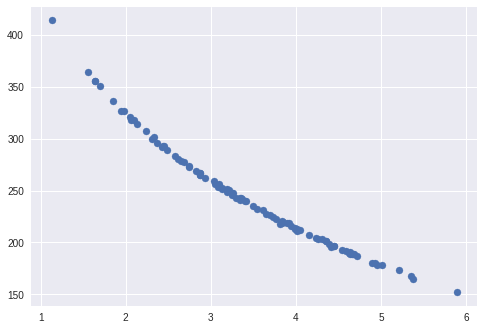

In [20]:
plt.scatter(tree_data.Nt, tree_data.Age)
plt.show()

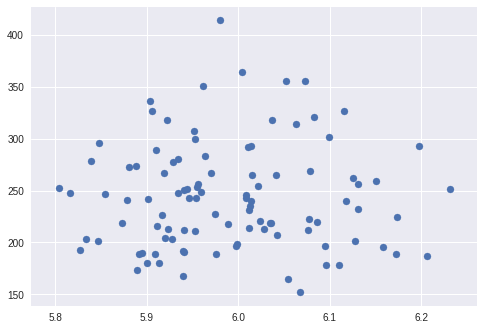

In [21]:
plt.scatter(tree_data.pH, tree_data.Age)
plt.show()

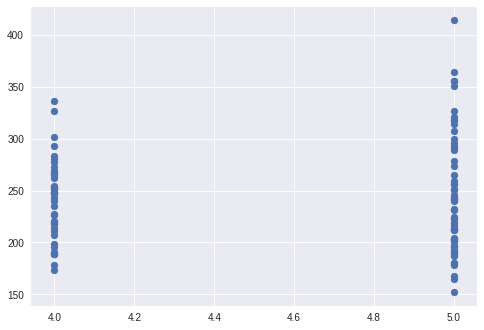

In [22]:
plt.scatter(tree_data.PetalCount, tree_data.Age)
plt.show()

## Making Train and Test Datasets

In [76]:
tree_data_y = tree_data['Age']
tree_data_x = tree_data.drop(['Age'], axis=1)

In [77]:
tree_data_x_train = tree_data_x[:int(0.8*len(tree_data_x))]
tree_data_y_train = tree_data_y[:int(0.8*len(tree_data_y))]
tree_data_x_test = tree_data_x[int(0.8*len(tree_data_x)):]
tree_data_y_test = tree_data_y[int(0.8*len(tree_data_y)):]

In [78]:
tree_data_x_train = tree_data_x_train.apply(lambda x: np.log(x))
tree_data_x_test = tree_data_x_test.apply(lambda x: np.log(x))

## Standardising the data

In [79]:
tree_data_stan_y_train = (tree_data_y_train-tree_data_y_train.mean())/tree_data_y_train.std()
tree_data_stan_x_train = (tree_data_x_train-tree_data_x_train.mean())/tree_data_x_train.std()
tree_data_stan_x_test = (tree_data_x_test-tree_data_x_test.mean())/tree_data_x_test.std()

## Linear Regression Model

In [80]:
reg = linear_model.LinearRegression(normalize=True)
reg.fit (tree_data_stan_x_train, tree_data_stan_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [81]:
tr_coeffs = reg.coef_
tr_resi = reg.residues_
tr_intr = reg.intercept_
print(pd.Series(tr_coeffs, index=tree_data_stan_x_test.columns))
print("Residuals: ", tr_resi)
print("Intercept: ", tr_intr)

N0            0.021275
Nt           -1.001992
pH           -0.000305
PetalCount   -0.000177
dtype: float64
Residuals:  0.000287464287129
Intercept:  1.83399895516e-15


/home/user/StackRoute/Assignments/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


In [85]:
pred_lin = reg.predict(tree_data_stan_x_test)

In [86]:
pred_lin = (pred_lin*tree_data_y_test.std())+tree_data_y_test.mean()

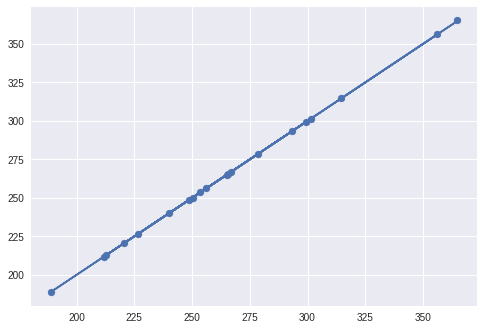

In [87]:
plt.scatter(tree_data_y_test, pred_lin)
plt.plot(tree_data_y_test, tree_data_y_test)
plt.show()

In [88]:
errors_abs = np.abs(tree_data_y_test-pred_lin)
errors = tree_data_y_test-pred_lin

In [89]:
errors.mean()

-1.6200374375330285e-13

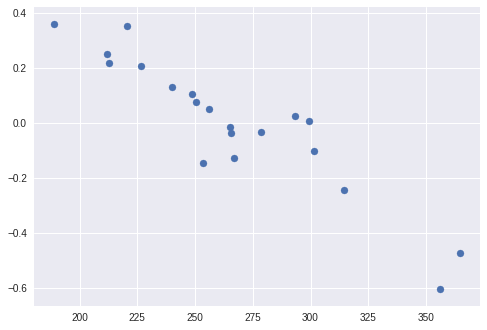

In [90]:
plt.scatter(tree_data_y_test, errors)
plt.show()

## Ridge Model

In [93]:
alphas_r = np.linspace(0.01,10,1000)*0.5

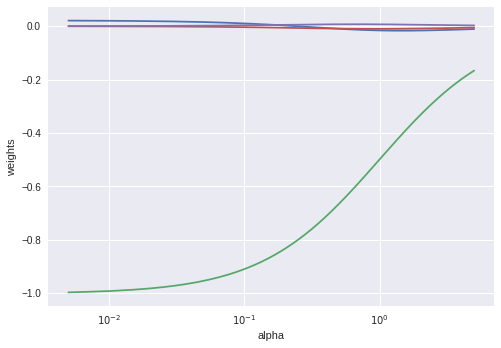

In [94]:
ridge = linear_model.Ridge(normalize=True)
coefs = []
for a in alphas_r:
    ridge.set_params(alpha=a)
    ridge.fit(np.array(tree_data_stan_x_train), np.array(tree_data_stan_y_train))
    coefs.append(ridge.coef_)
ax = plt.gca()
ax.plot(alphas_r, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [95]:
ridgecv = linear_model.RidgeCV(alphas=alphas_r, scoring='neg_mean_squared_error', normalize=True)
ridgecv.fit(np.array(tree_data_stan_x_train), np.array(tree_data_stan_y_train))
ridgecv.alpha_
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(np.array(tree_data_stan_x_train), np.array(tree_data_stan_y_train))
pred = ridge.predict(tree_data_stan_x_test)
mean_squared_error(tree_data_y_test, (pred*tree_data_y_test.std())+tree_data_y_test.mean())

0.010371012281371588

In [96]:
print(pd.Series(ridge.coef_, index=tree_data_stan_x_test.columns))
print("Intercept: ", ridge.intercept_)
print("Aplha: ", ridge.alpha)

N0            0.020609
Nt           -0.996927
pH           -0.000524
PetalCount    0.000027
dtype: float64
Intercept:  1.83320829999e-15
Aplha:  0.005


In [97]:
pred_ridge = (ridge.predict(tree_data_stan_x_test)*tree_data_y_test.std())+tree_data_y_test.mean()

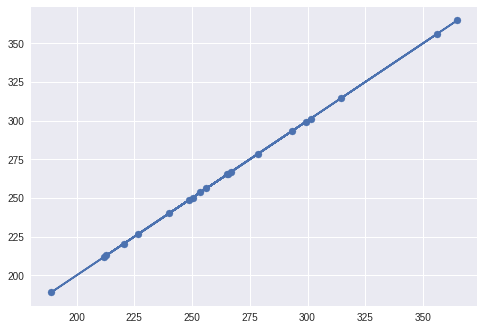

In [98]:
plt.scatter(tree_data_y_test, pred_ridge)
plt.plot(tree_data_y_test, tree_data_y_test)
plt.show()

In [99]:
errors_abs = np.abs(np.array(tree_data_y_test)-pred_ridge)
errors = np.array(tree_data_y_test).reshape(20,1)-pred_ridge.reshape(20,1)

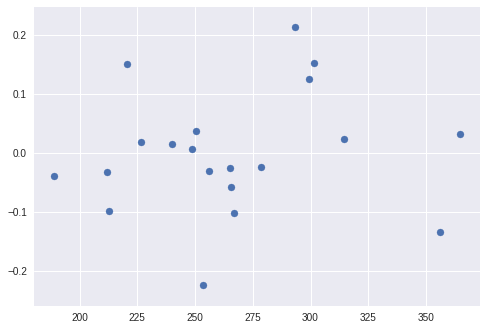

In [100]:
plt.scatter(np.array(tree_data_y_test).reshape(20,1), errors)
plt.show()

## Lasso Model

In [101]:
alphas = np.linspace(0.0001,1,1000)*0.5

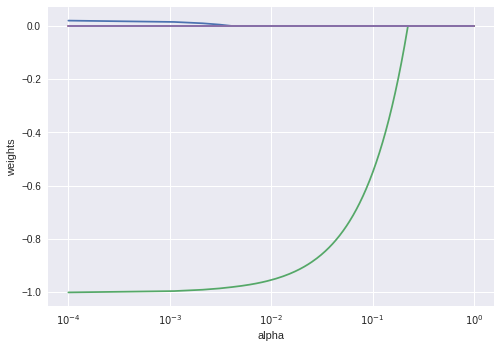

In [102]:
lasso = linear_model.Lasso(max_iter = 10000, normalize=True)
coeffs = []
for al in alphas:
    lasso.set_params(alpha=al)
    lasso.fit(np.array(tree_data_stan_x_train), np.array(tree_data_stan_y_train))
    coeffs.append(lasso.coef_)
ax = plt.gca()
ax.plot(2*alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [103]:
lassocv = linear_model.LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(np.array(tree_data_stan_x_train), np.array(tree_data_stan_y_train))
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(np.array(tree_data_stan_x_train), np.array(tree_data_stan_y_train))
pred = lasso.predict(tree_data_stan_x_test)
mean_squared_error(tree_data_y_test, (pred*tree_data_y_test.std())+tree_data_y_test.mean())

0.041545737328727336

In [104]:
print(pd.Series(lasso.coef_, index=tree_data_stan_x_test.columns))
print("Intercept: ", lasso.intercept_)
print("Aplha: ", lasso.alpha)

N0            0.020117
Nt           -1.000882
pH           -0.000000
PetalCount   -0.000000
dtype: float64
Intercept:  1.87447385213e-15
Aplha:  0.000111077427809


In [105]:
pred_lasso = (lasso.predict(tree_data_stan_x_test)*tree_data_y_test.std())+tree_data_y_test.mean()

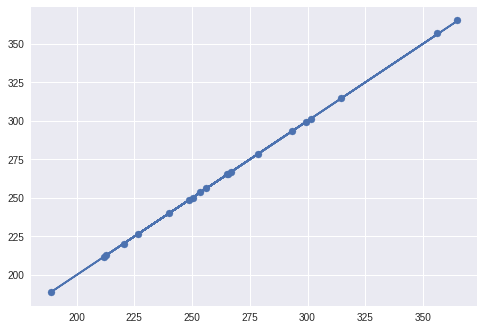

In [106]:
plt.scatter(tree_data_y_test, pred_lasso)
plt.plot(tree_data_y_test, tree_data_y_test)
plt.show()

In [107]:
errors_abs = np.abs(np.array(tree_data_y_test)-pred_lasso)
errors = np.array(tree_data_y_test).reshape(20,1)-pred_lasso.reshape(20,1)

In [108]:
errors.mean()

-1.4779288903810084e-13

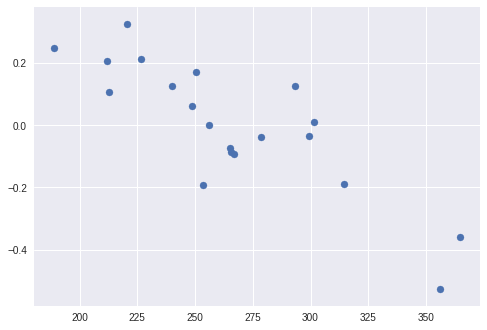

In [109]:
plt.scatter(np.array(tree_data_y_test).reshape(20,1), errors)
plt.show()

## Histogram of Errors

In [110]:
y = pd.DataFrame(errors)

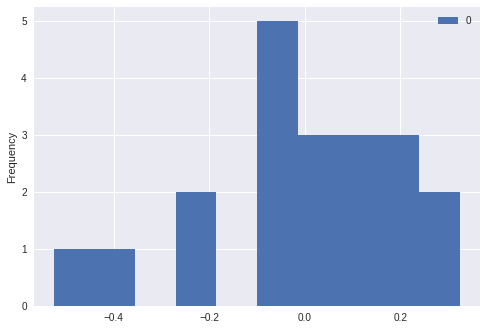

In [111]:
y.plot(kind = 'hist')
plt.show()

## Box Plot

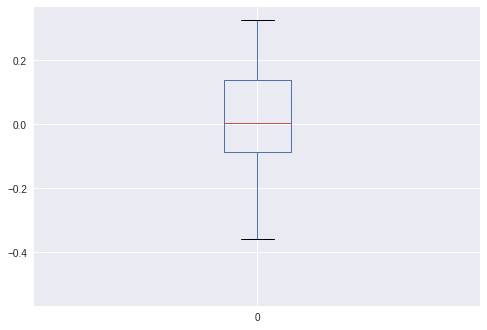

In [112]:
y.plot(kind = 'box')
plt.show()